# Iterative Activation Calculations

This notebook illustrates how intermodal competition in droplet activation calculations impacts how many droplets are ultimately nucleated, and highlights the concept behind the "greedy" activation calculations. 

> **Note**
> To run this notebook, you'll need to have a working installation of the [parcel model](https://github.com/darothen/parcel_model) previously described in [Rothenberg and Wang (2015)][Rothenberg2015].


[Rothenberg2015]: http://dx.doi.org/10.1175/JAS-D-15-0223.1
[Whitby1978]: http://linkinghub.elsevier.com/retrieve/pii/S1352231007009739

## Setup/Prerequisites

We have a few basic imports to setup, including setting the plotting environment and importing the parcel model to run later.

In [1]:
import parcel_model as pm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import cycler
sns.set(style='ticks', context='talk')

FIG_ASPECT = 16./12.
FIG_WIDTH = 5.
FIG_HEIGHT = FIG_WIDTH/FIG_ASPECT

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Within the `parcel_model` distribution are hard-coded aerosol size distributions from [Whitby (1978)][Whitby1978]. You can re-run the simulation/calculations with any of the following pre-sets:

- marine
- urban
- remote
- continental

[Whitby1978]: http://linkinghub.elsevier.com/retrieve/pii/S1352231007009739

In [2]:
dist_name = 'marine'
aer_colors = sns.color_palette('deep', 3)

modes = ['nucleation', 'accumulation', 'coarse']

dist = pm.distributions.whitby_distributions[dist_name]
dists = {name: d for name, d in 
         zip(modes, dist)}

print(dists[modes[0]])

Lognorm | mu = 5.00e-03, sigma = 1.60e+00, Total = 3.40e+02 |


## Parcel Model Simulations

Next, we run the greedy iterative calculations. This is essentially identical to the algorithm we'll run on the more complex, MARC-simulated aerosol size distributions, although in that application we do not need to hard-code the meteorology as we do here.

In [3]:
# Meteorology pre-sets
model_settings = {
    'V': 0.5,    # Updraft speed, m/s
    'P0': 85000, # Initial pressure, Pa
    'T0': 283.,  # Initial temperature, K
    'S0': -0.01, # Initial relative humidity, as supersaturation 
}

In [4]:
def calc_smax(aerosols):
    """ Sentinel to run a parcel model simulation and report a 
    trace of its output. """
    model = pm.ParcelModel(aerosols, **model_settings)
    pout, aout = model.run(3600., output_dt=5.0, model_dt=20,
                           solver='cvode', terminate=True,
                           terminate_depth=800.)
    return pout, aout

aerosol_map = {
    name: pm.AerosolSpecies(name, d, bins=200, kappa=0.56)
               for name, d in dists.items()}

# Algorithm to run the actual simulations, saving whichever aerosol mode 
# produces the lowest supersaturation maximum at each iteration.
iter_modes = []
iter_smax = []
iter_trace = []
available_modes = [aerosol_map[name] for name in aerosol_map.keys()]
it = 1
iter_dicts = []
while available_modes:
    print("Iteration {:2d}".format(it))
    
    min_smax = 9999.
    min_i = 0
    trace_save = None
    current_iter_dict = {}
    for i, mode in enumerate(available_modes):
        print("   mode {:2d}:".format(i), end=" ")
        mode = available_modes[i]
        for mode in iter_modes + [mode, ]:
            print(mode.species, end=" ")
    
        pout, _ = calc_smax(iter_modes + [mode, ])
        test_smax = pout.S.max()
        test_trace = pout
        if test_smax < min_smax:
            min_i = i
            min_smax = test_smax
            trace_save = pout
        print("{:1.4f}".format(test_smax))
        
        key = "+".join([mode.species for mode in iter_modes] + [mode.species, ])
        current_iter_dict[key] = pout
        
    min_mode = available_modes.pop(min_i)
    iter_modes.append(min_mode)
    iter_smax.append(min_smax)
    iter_trace.append(trace_save)
    print("\nCHOOSE {}\n".format(min_mode))
    
    iter_dicts.append(current_iter_dict)
    
    it += 1

Iteration  1
   mode  0: accumulation Could not find GLIMDA
[CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
0.0123
   mode  1: nucleation [CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
0.0136
   mode  2: coarse [CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
0.0148

CHOOSE accumulation - Lognorm | mu = 3.50e-02, sigma = 2.00e+00, Total = 6.00e+00 |

Iteration  2
   mode  0: accumulation nucleation [CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
0.0108
   mode  1: accumulation coarse [CVode Warning] b'At the end of the first step, there are still some root functions identically 0. This warning will not be issued again.'
0.0096



/Users/daniel/workspace/Research/parcel_model/parcel_model/integrator.py:20: UserWarning: Could not import odespy package; invoking the 'lsoda' or 'lsode' options will fail!
  warnings.warn("Could not import odespy package; "


## Plots and Analysis

accumulation - Lognorm | mu = 3.50e-02, sigma = 2.00e+00, Total = 6.00e+00 |
      coarse - Lognorm | mu = 3.10e-01, sigma = 2.70e+00, Total = 3.10e+00 |
  nucleation - Lognorm | mu = 5.00e-03, sigma = 1.60e+00, Total = 3.40e+02 |
accumulation (0.10588235408067703, 0.61960786581039429, 0.46666666865348816)
accumulation+coarse (0.84221454166314191, 0.3754556017763474, 0.013241061612087046)
accumulation+coarse+nucleation (0.46057670373542647, 0.43812380216869645, 0.70133027539533721)


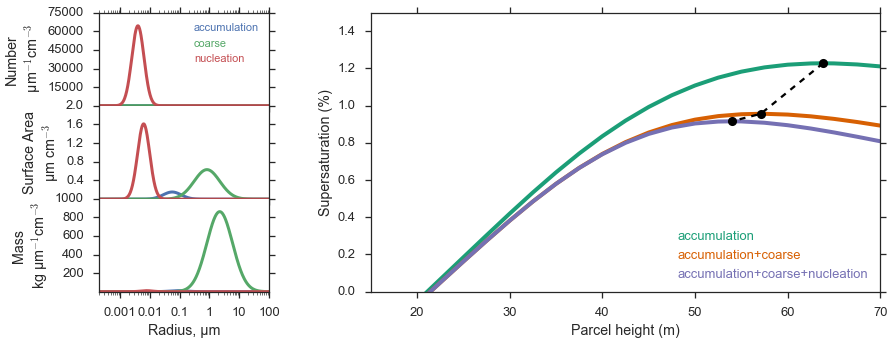

In [129]:
from matplotlib.gridspec import GridSpec
from util import colortext_legend
from collections import OrderedDict
from string import ascii_lowercase as letters

# Set up the plot grid layout
plt.figure(figsize=(14, 5))
ax_grid = GridSpec(3, 2, hspace=0., wspace=0.3,
                   width_ratios=[1, 3])
axN = plt.subplot(ax_grid[0, 0])
axS = plt.subplot(ax_grid[1, 0])
axM = plt.subplot(ax_grid[2, 0])
axP = plt.subplot(ax_grid[:, 1])

aer_rho = 1000. # kg/m3
rs = np.logspace(-4, 2, 500) # aerosol dry radii, micron

color_map = OrderedDict()
for (name, d), color in zip(dists.items(), aer_colors):
    print("{:>12s} - {}".format(name, d))
    
    line_kws = dict(label=name, color=color, lw=3)
    
    aer = pm.AerosolSpecies(name, d, bins=200, kappa=0.56)
    dist_pdf = d.pdf
    
#     axN.plot(rs, dist_pdf(rs)*rs, **line_kws)
#     axS.plot(rs, (rs**2)*dist_pdf(rs)*rs, **line_kws)
#     axM.plot(rs, (rs**3)*aer_rho*dist_pdf(rs)*rs, **line_kws)
    axN.plot(rs, dist_pdf(rs), **line_kws)
    axS.plot(rs, (rs**2)*dist_pdf(rs), **line_kws)
    axM.plot(rs, (rs**3)*aer_rho*dist_pdf(rs), **line_kws)
    color_map[name] = color

for i, ax in enumerate([axN, axS, axM]):
    ax.semilogx()
    ax.set_xlim(2e-4, 100.)
    
    # Limit max number of ticks on y-axis
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    
    # Get rid of "0" tick
    ax.set_ylim(1e-2, ax.get_ylim()[-1])
    ax.set_yticks(ax.get_yticks()[1:])
    
    if i > 0:
        sns.despine(ax=ax, top=True, right=False)
    if i < 2:
        ax.xaxis.set_ticklabels("")
    
_ = colortext_legend(color_map, ax=axN, fontsize=11)
axM.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%1g"))

axM.set_xlabel("Radius, µm")
axN.set_ylabel("Number\n µm$^{-1}$cm$^{-3}$")
axS.set_ylabel("Surface Area\nµm cm$^{-3}$")
axM.set_ylabel("Mass\nkg µm$^{-1}$cm$^{-3}$")

##################################################################

colors = iter(sns.color_palette("Dark2", 3))
mode_labels = []
color_map = OrderedDict()
for (trace, mode) in zip(iter_trace, iter_modes):
    mode_labels.append(mode.species)
    label = "+".join(mode_labels)
    color = next(colors)
    print(label, color)

    l = axP.plot(trace.z, trace.S*100, color=color, label=label, lw=4)
    color_map[label] = color
        
smaxes = [trace.S.max()*100 for trace in iter_trace]
z_at_smax = [trace.z.ix[trace.S.argmax()] for trace in iter_trace]
axP.plot(z_at_smax, smaxes, linestyle='dashed', color='k', marker='o')
    
axP.set_xlim(15, 70)
axP.set_ylim(0., 1.5)

axP.set_xlabel("Parcel height (m)")
axP.set_ylabel("Supersaturation (%)")

# axP.yaxis.set_label_position("right")
# axP.yaxis.tick_right()
# sns.despine(ax=axP, left=True, right=False)

_ = colortext_legend(color_map, ax=axP, loc='lower right')

fn = "figs/{}_combo_plot".format(dist_name)
plt.savefig(fn+".png", transparent=True, bbox_inches='tight', dpi=200)
plt.savefig(fn+".pdf", transparent=True, bbox_inches='tight')

In [130]:
def multimode_lognormal_nact(aerosols, smax, T=model_settings['T0']):
    aerosols = np.asarray(aerosols)
    nact = 0
    for mode in aerosols:
        dist = mode.distribution
        # print(mode.species, mode.total_N, end=' ')
        n_mode, _ = pm.lognormal_activation(smax, 
                                            dist.mu*1e-6, dist.sigma, dist.N, mode.kappa,
                                            T=T)
        # print(n_mode)
        nact += n_mode
    return nact

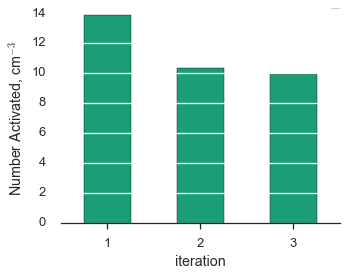

In [131]:
iter_nacts = [multimode_lognormal_nact(iter_modes, smax) for smax in iter_smax]
total_num = np.sum([mode.total_N for mode in iter_modes])
import pandas as pd
df = pd.DataFrame({'nact': iter_nacts, 'smax': iter_smax},
                  index=pd.Index([1,2,3], name="iteration"))
df = df.assign(smax_relerr=(df.smax.ix[1] - df.smax))

fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
ax = fig.add_subplot(111)

df['nact'].plot(kind='bar', rot=0, colormap="Dark2", ax=ax, zorder=-10,
                edgecolor=None)
ax.set_ylabel("Number Activated, cm$^{-3}$")
ax.set_title("Total Number = {:4d}".format(int(total_num)), loc='right',
             fontsize=1)

# set up grid
ax.grid(True, axis='y', color='w')
ax.tick_params(axis='y', length=0)

sns.despine(left=True, ax=ax)

fig_fn = "{}_multimode_nact".format(dist_name)
plt.savefig(fig_fn+".pdf", transparent=True, bbox_inches='tight')
plt.savefig(fig_fn+".png", transparent=True, bbox_inches='tight', dpi=200)